# Predicting the rating of Epicurious recipes

In this project I am looking at the [Epicurious - Recipes with Rating and Nutrition](https://www.kaggle.com/hugodarwood/epirecipes/notebooks) dataset. This is a high dimensional dataset containing over 20,000 recipes with nutrition information and various tags, such as "christmas", "vegan" or "dessert".

First, I explore and clean the data. Then, I run regularized regressions (lasso and ridge) and XGBoost to predict the rating of a recipe using nutrition information and recipe tags. For lasso and ridge regression, I use a simple grid search to find optimal model hyperparameters. For XGBoost, I apply bayesian optimization using the hyperopt package.


### Table of Contents

* [1 Preparations](#prep)
* [2 Data Cleaning & Exploratory Data Analysis](#eda)
* [3 Predicting recipe ratings](#models)
    * [3.1 Regularized Regression](#regressions)
    * [3.2 XGBoost](#xgb)
        * [3.2.1 Hyperparameter optimization](#xgb_hypopt)
        * [3.2.2 Feature importance](#xgb_importance)
* [4 Summary](#summary)

## 1. Preparations <a class="anchor" id="prep"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Set style parameters
sns.set_style("whitegrid")

/Users/matevaradi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load data
recip=pd.read_csv("epi_r.csv")
recip.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data Cleaning & Exploratory Data Analysis <a class="anchor" id="eda"></a>
In this section, I will start exploring the data through visualizations and statistics, and clean the dataset as we go.

In [3]:
recip.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The dataset has three types of numerical variables:
* **Nutritional variables**: Calories, protein, fat and sodium. 
* **Tags**: 675 dummy variables indicating whether a tag was used for the recipe or not. 
* **Rating**: the average rating for the recipe. Unfortunately, we have no information on the number of reviews that produce this average. Therefore we cannot have high confidence in this variable, as the number of ratings that produced the average can be as low as 1 in some cases.


Now let's look into these three variable categories in more detail.
#### Nutritional variables

From the table above we can immediately see that some values do not seem to make sense. 
For example there are recipes that have over 1000 grams of protein. Furthermore, we know that a gram of protein has 4 grams and a gram of fat has 9 calories. Therefore, if the number of calories in the recipe is below protein $\times$ 4 + fat $\times$ 9, we can take that as a sign of flawed data. Let's get rid of these nonsense datapoints:

In [4]:
# Deleting nutrition data from recipes with protein>1000. This seems too much to be real.
recip.loc[recip["protein"]>1000,["calories","protein","fat","sodium"]]=np.nan
# Deleting nutrition data from recipes where cal< fat*9 + protein*4. 
# We leave a 30 kcal buffer for error in the calculation
recip.loc[(4*recip["protein"]+9*recip["fat"])>recip["calories"]+30,["calories","protein","fat","sodium"]]=np.nan

Let's create a copy of the data where we delete NaNs. We'll keep NaNs in the original dataset. Later on we'll see why.

In [5]:
print(recip.columns[recip.isnull().any()])
recip2=recip.dropna()
print(recip2.shape)

Index(['calories', 'protein', 'fat', 'sodium'], dtype='object')
(15850, 680)


The new dataset, <recip2> has about 5000 recipes less. We'll now look at the distribution of the nutritional variables.


Text(0.5, 0.98, 'Distribution of available calorie, macro- and micronutrient content of recipes')

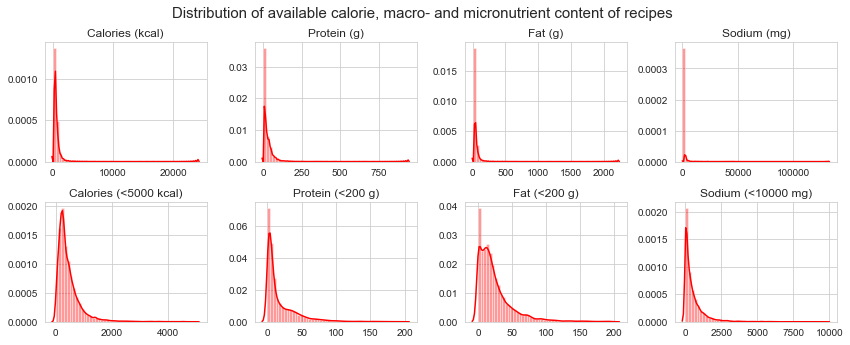

In [6]:
f, axes = plt.subplots(2, 4,figsize=(12,5))

sns.distplot(recip2["calories"],color="red",ax=axes[0,0]).set(title="Calories (kcal)",xlabel="")
sns.distplot(recip2["protein"],color="red",ax=axes[0,1]).set(title="Protein (g)",xlabel="")
sns.distplot(recip2["fat"],color="red",ax=axes[0,2]).set(title="Fat (g)",xlabel="")
sns.distplot(recip2["sodium"],color="red",ax=axes[0,3]).set(title="Sodium (mg)",xlabel="")


sns.distplot(recip2.loc[recip.calories<5000,"calories"],color="red",ax=axes[1,0]).set(
    title="Calories (<5000 kcal)",xlabel="")
sns.distplot(recip2.loc[recip.protein<200,"protein"],color="red",ax=axes[1,1]).set(
    title="Protein (<200 g)",xlabel="")
sns.distplot(recip2.loc[recip.fat<200,"fat"],color="red",ax=axes[1,2]).set(
    title="Fat (<200 g)",xlabel="")
sns.distplot(recip2.loc[recip.sodium<10000,"sodium"],color="red",ax=axes[1,3]).set(
    title="Sodium (<10000 mg)",xlabel="")

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Distribution of available calorie, macro- and micronutrient content of recipes", fontsize=15)

#### Tags

The easiest way to understand how the recipes are tagged are through looking at some examples.

In [7]:
print(recip.iloc[0].title)
recip.columns[6:][recip.iloc[0,6:]>0]

Lentil, Apple, and Turkey Wrap 


Index(['apple', 'bean', 'cookie', 'fruit', 'kid-friendly', 'lentil', 'lettuce',
       'sandwich', 'tomato', 'vegetable', 'turkey'],
      dtype='object')

In [8]:
print(recip.iloc[1].title)
recip.columns[6:][recip.iloc[1,6:]>0]

Boudin Blanc Terrine with Red Onion Confit 


Index(['bake', 'bastille day', 'bon appétit', 'chill', 'dried fruit',
       'food processor', 'new year's eve', 'onion', 'pork', 'port', 'winter'],
      dtype='object')

The first recipe in the data has ingredient tags, along with "kid-friendly". The tags of the second recipe suggest that it should be eaten in the winter (New Year's Eve) or on Bastille Day (which is in July). The title along with the tag "bon appétit" suggests that it's a french recipe, but the tag "france" is not used.  So I assume that whoever writes the recipe can use whatever tags they want. Often, they use ingredients in the tags. Here are all the tags in the dataset:

In [9]:
for tag in list(recip.columns[6:]):
        print(tag)

#cakeweek
#wasteless
22-minute meals
3-ingredient recipes
30 days of groceries
advance prep required
alabama
alaska
alcoholic
almond
amaretto
anchovy
anise
anniversary
anthony bourdain
aperitif
appetizer
apple
apple juice
apricot
arizona
artichoke
arugula
asian pear
asparagus
aspen
atlanta
australia
avocado
back to school
backyard bbq
bacon
bake
banana
barley
basil
bass
bastille day
bean
beef
beef rib
beef shank
beef tenderloin
beer
beet
bell pepper
berry
beverly hills
birthday
biscuit
bitters
blackberry
blender
blue cheese
blueberry
boil
bok choy
bon appétit
bon app��tit
boston
bourbon
braise
bran
brandy
bread
breadcrumbs
breakfast
brie
brine
brisket
broccoli
broccoli rabe
broil
brooklyn
brown rice
brownie
brunch
brussel sprout
buffalo
buffet
bulgaria
bulgur
burrito
butter
buttermilk
butternut squash
butterscotch/caramel
cabbage
cake
california
calvados
cambridge
campari
camping
canada
candy
candy thermometer
cantaloupe
capers
caraway
cardamom
carrot
cashew
casserole/gratin
cauliflowe

Let's count how many times each of the tags occur (or how often the dummies take the value 1)

In [10]:
tag_counts=dict()
for tag in recip.iloc[:,6:].columns:
    count=sum(recip[tag])
    tag_counts[tag]=int(count)

The count dictionary can be used to get the most and least frequent tags:

In [11]:
top_10_tags=dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:10])
bottom_10_tags=dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=False)[:10])

print("The most popular tags are: ")
for tag,count in top_10_tags.items():
    print(tag,"appears",count," times")
print("\n Some of the least popular tags are: ")
for tag,count in bottom_10_tags.items():
    if count==1:
        print(tag,"appears once")
    else:
        print(tag,"appears",count," times")

The most popular tags are: 
bon appétit appears 9355  times
peanut free appears 8390  times
soy free appears 8088  times
tree nut free appears 7044  times
vegetarian appears 6846  times
gourmet appears 6648  times
kosher appears 6175  times
pescatarian appears 6042  times
quick & easy appears 5372  times
wheat/gluten-free appears 4906  times

 Some of the least popular tags are: 
#wasteless appears once
aspen appears once
beverly hills appears once
bulgaria appears once
burrito appears once
camping appears once
caviar appears once
costa mesa appears once
crêpe appears once
cr��me de cacao appears once


It a tag only appear a few times in the data, then it's use for regressions can be problematic and can lead to overfitting. Therefore, in the <recip2> dataset, we will only keep the tags, that appear at least 51 times among the recipes.

In [12]:
common_tags=list(dict(filter(lambda elem: elem[1] > 50, tag_counts.items())).keys())
base_cols=["title","rating","calories","protein","fat","sodium"]
recip2=recip2[base_cols+common_tags]
print(recip2.shape)

(15850, 369)


#### Rating

Finally, let's examine the distribution of the dependent variable:

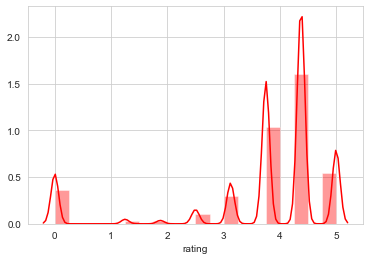

In [13]:
sns.distplot(recip["rating"],color="red",bins=20)

It appears that most recipes have very high ratings. 

Finally, we look at a visualization of the correlation matrix of the variables that have the highest correlation with rating:

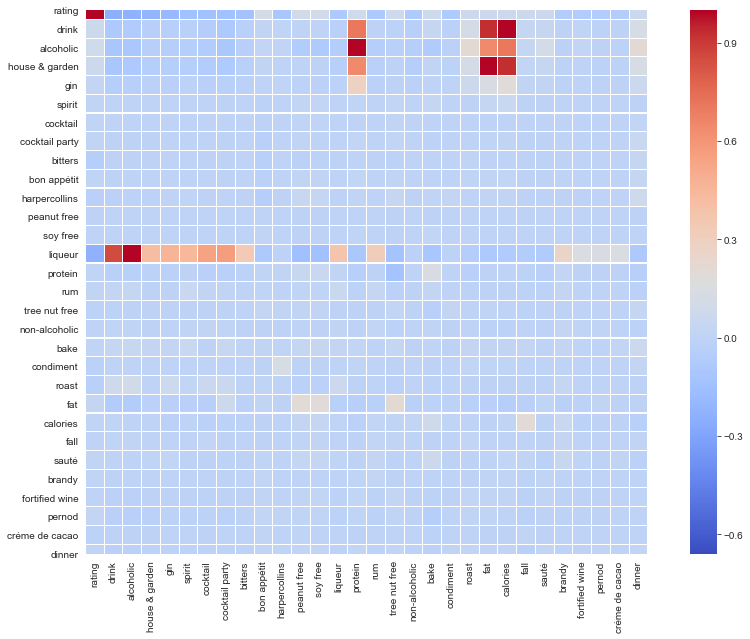

In [14]:
corr = recip.corr()

# select the 50 columns that has the highest correlation with rating
corr_cols=list(corr.iloc[0,abs(corr["rating"]).values.argsort()[-30:][::-1]].index)

plt.figure(figsize = (15,10))
# plot a heatmap of the correlation matrix
sns.heatmap(corr[corr_cols], 
        xticklabels=corr_cols,
        yticklabels=corr_cols,
           linewidths=.1,cmap="coolwarm",square=True)

## 3. Predicting the rating <a class="anchor" id="models"></a>
Our dependent variable y is the average rating of the recipe. Our X matrix consists of the nutritional variables and the common tag dummies that we just selected.

In [15]:
X,y=recip2.iloc[:,2::],recip2.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

### 3.1 Regularized regression <a class="anchor" id="regressions"></a>
The first model I'll use is linear regression. However, because of the large number of variables, I will use regularized regression. I apply both L1 (Lasso Regression) and L2 (Ridge Regression) regularization to the coefficients. 

The best regularization parameter ($\alpha$) will be determined via grid search. 

In [16]:
# Model initialization
lasso = Lasso(random_state=24)
ridge = Ridge(random_state=24)
elasticnet = ElasticNet(random_state=24)

# Prepare gridsearch cv
alphas = np.linspace(0.000001,10,10)
l1_ratio = np.linspace(0,1,10)
n_folds=5

# Perform gridsearch
## Lasso
lasso_grid = GridSearchCV(estimator=lasso, param_grid=dict(alpha=alphas),
                          scoring="neg_root_mean_squared_error",cv=n_folds)
lasso_grid.fit(X, y)

## Ridge
ridge_grid = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas),
                          scoring="neg_root_mean_squared_error",cv=n_folds)
ridge_grid.fit(X, y)

# Display results
print("The best alpha parameter for lasso regression:",lasso_grid.best_estimator_.alpha,
      "with best RMSE: ", np.round(-lasso_grid.best_score_,4))
print("The best alpha parameter for ridge regression:",ridge_grid.best_estimator_.alpha,
      "with best RMSE: ", np.round(-ridge_grid.best_score_,4))


The best alpha parameter for lasso regression: 1e-06 with best RMSE:  1.198
The best alpha parameter for ridge regression: 10.0 with best RMSE:  1.1951


Interestingly, the optimal $\alpha$ values are on the two opposite ends of the range that we provided for the grid search. Ridge regression, which uses high regularization appears to be perform better in terms of RMSE.

We can visualize cross-validated RMSE as a function of $\alpha$:

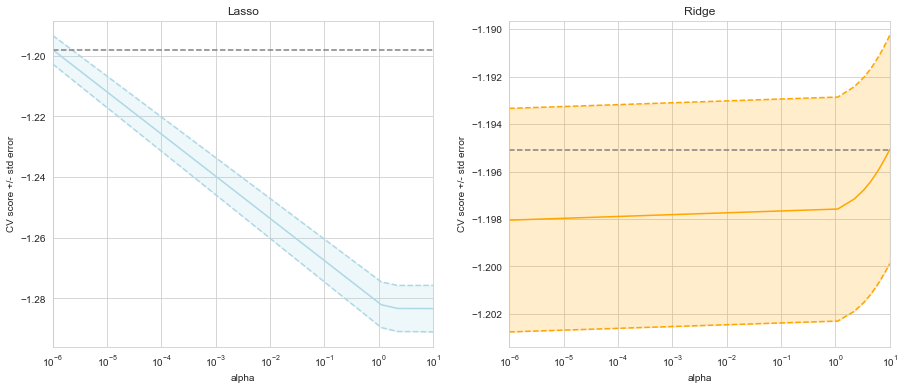

In [17]:
titles=["Lasso","Ridge"]
colors=["lightblue","orange"]
fig, axs = plt.subplots(1,2, figsize=(15, 6))

for i,fits in enumerate([lasso_grid,ridge_grid]):
    scores=fits.cv_results_['mean_test_score']
    scores_std = fits.cv_results_['std_test_score']
    axs[i].semilogx(alphas, scores,color=colors[i])
    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)
    axs[i].semilogx(alphas, scores + std_error, 'b--',color=colors[i])
    axs[i].semilogx(alphas, scores - std_error, 'b--',color=colors[i])
    # alpha=0.2 controls the translucency of the fill color
    axs[i].fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2,color=colors[i])
    axs[i].set_ylabel('CV score +/- std error')
    axs[i].set_xlabel('alpha')
    axs[i].axhline(np.max(scores), linestyle='--', color='.5')
    axs[i].set_xlim([alphas[0], alphas[-1]])
    axs[i].set_title(titles[i])



In [18]:
lasso_best=Lasso(alpha=1e-06)
ridge_best=Ridge(alpha=10)

lasso_best.fit(X_train,y_train)
ridge_best.fit(X_train,y_train)

lasso_preds = lasso_best.predict(X_test)
ridge_preds = ridge_best.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print("Lasso RMSE:",lasso_rmse)
print("Ridge RMSE:",ridge_rmse)

Lasso RMSE: 1.1935078909415513
Ridge RMSE: 1.1889515418841012


Running both models with the optimal $\alpha$ ultimately results in a lower RMSE for ridge regression than for lasso.

What's nice about linear regression is that we can investigate the effect of individual variables. Although causal statements cannot be made in this case, we can still examine whether a variable has a positive or negative effect on ratings:

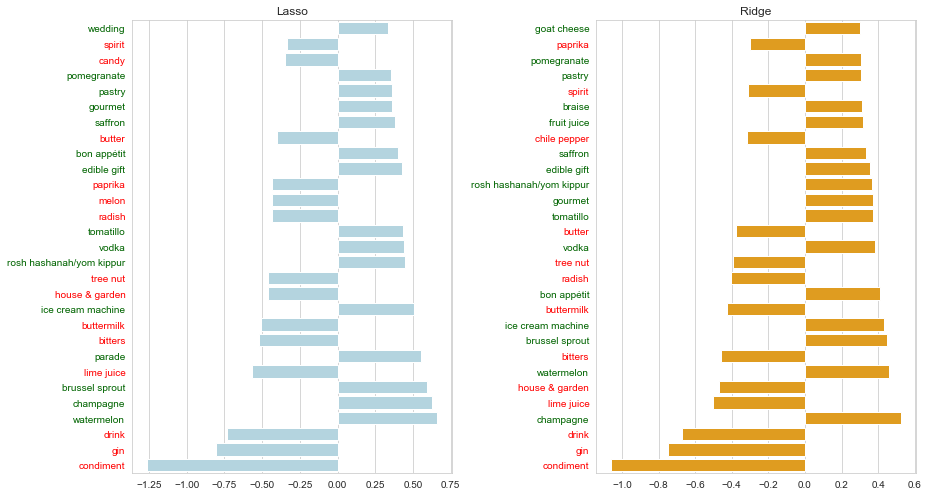

In [30]:
lasso_coef=lasso_best.coef_
ridge_coef=ridge_best.coef_
coef_names=recip2.columns[2:]

f,axes=plt.subplots(1,2,figsize=(13,7))

sns.barplot(y=coef_names[np.argsort(abs(lasso_coef))][-30:-1],x=lasso_coef[np.argsort(abs(lasso_coef))][-30:-1],
            orient="h",color="lightblue",ax=axes[0])
sns.barplot(y=coef_names[np.argsort(abs(ridge_coef))][-30:-1],x=ridge_coef[np.argsort(abs(ridge_coef))][-30:-1],
            orient="h",color="orange",ax=axes[1])

axes[0].set(title="Lasso")
axes[1].set(title="Ridge")
# Display which variable has a positive effect through color
[label.set_color("darkgreen") if lasso_coef[np.argsort(abs(lasso_coef))][-30:-1][i]>0 else label.set_color("red")
  for i, label in enumerate(axes[0].get_yticklabels())]

[label.set_color("darkgreen") if ridge_coef[np.argsort(abs(ridge_coef))][-30:-1][i]>0 else label.set_color("red")
  for i, label in enumerate(axes[1].get_yticklabels())]

plt.tight_layout()

plt.savefig("epicurious_reg_coefs.png")


The 30 variables with the largest coefficients are visualized for both Lasso and Ridge. Note that this does not mean that these are the 30 most important features, as the variables are on different scales. On the figures, when a variable is written in red it means that it has a negative effect on rating, while green text indicates positive effect. For example, the tags "drink", "gin" and "condiment" have the strongest negative effects on ratings, whereas "bon appétit", "brussel sprout" (surprisingly) and "champagne" have the strongest positive effect. 

### 3.2 XGBoost <a class="anchor" id="xgb"></a>
This dataset is relatively big and high-dimensional, therefore it seems like an ideal dataset for XGBoost. XGBoost is a popular machine learning algorithm similar to Gradient Boosting. Some of XGBoost's advantages include its speed (it implements parallel processing), flexibility along with various strategies implemented to prevent overfitting. I won't go into the details of this method in this notebook, but it is important to talk a bit about the many (hyper)parameters of XGBoost.

General parameters:

* __booster__: gbtree, gblinear or dart.We will use gbtree, as it usually outperforms gblinear.
* __verbosity__ : whether preliminary results should be printed
* __nthread__: number of parallel threads used to run XGBoost. When we want to run on all cores, this value should not be entered.

Booster parameters: 
* __eta__: learning_rate, the step size shrinkage used to prevent overfitting. It's range is [0,1].
* __gamma__: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. 
* __max_depth__: determines how big each tree is allowed to grow during any boosting round.
* __min_child_weight__: It defines the minimum sum of weights of all observations required in a leaf.
* __subsample__: percentage of samples used per tree. A low value can lead to underfitting.
* __colsample_bytree__: percentage of features used per tree. High value can lead to overfitting.
     __colsample_bylevel__: percentage of features used at each level. Subsampling occurs once for every new depth level reached in a tree. 
     __colsample_bynode__: percentage of features used for each node (split). Subsampling occurs once every time a new split is evaluated. 
* __alpha: L1__ regularization on leaf weights. A large value leads to more regularization.
* __lambda__: L2 regularization on leaf weights. It is smoother than L1 regularization.
* __n_estimators__: number of trees you want to build.

Learning Task Parameters
* __objective__: determines the loss function to be used, such as reg:linear for regression problems, reg:logistic for classification problems with decision only, binary:logistic for classification problems with probability.
* __eval_metric__: The metric to be used for validation, such as rmse or auc.
* __seed__: the random number seed (for replication).


First, let's run XGBoost with some randomly selected parameters.

In [20]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.2,
                max_depth = 7, alpha = 10, n_estimators = 20,gamma=9)

xgb_reg.fit(X_train,y_train)

preds = xgb_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:",rmse)

RMSE: 1.1792530111587118


We can see that it already performs better than our lasso and ridge regressions.

### 3.2.1 Hyperparameter optimization <a class="anchor" id="xgb_hypopt"></a>

For the regularized regressions of the previous section we used grid search to find the optimal hyperparameters (or hyperparameter combinations). This involves defining the hyperparameter values that we want to try and running the model with each combination k times, each time saving the validation metric (root mean squared error in our case). Another alternative for finding hyperparameter combinations is random search. However, these methods are relatively inefficient because they are completely uninformed by past evaluations. When we have many hyperparameters to optimize, such as in the case of XGBoost, we might want something more efficient, such as Bayesian optimization. Bayesian optimization can choose the next hyperparameters to evaluate based on previous results, therefore no time will be wasted by running "bad" models ([5](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)). 

Instead of the objective function, we will optimize a surrogate function. One algorithm that can do Bayesian optimziation is the Tree Parzen Estimator (TPE). In a nutshell, it constructs the surrogate function and selects the next hyperparameters using Expected Improvement.

The steps of Bayesian optimization are the following:

1. Initialize domain space:

      The domain space contains the input values over which we want to search.
      

2. Define objective function

      The objective function can be any function which returns a real value that we want to minimize. In our case, we want to minimize the test RMSE of the XGBoost model with respect to the hyperparameters. 
      

3. Perform the optimization

      We will use the TPE algorithm.


4. Look at the results


We can perform all these steps with the hyperopt package. 

To initalize the domain space we can choose from the following hyperopt functions:

* `hp.choice(label, options)` - Returns one of the options, which should be a list or tuple.

* `hp.randint(label, upper)`  - Returns a random integer between the range [0, upper).

* `hp.uniform(label, low, high)` — Returns a value uniformly between low and high.

* `hp.quniform(label, low, high, q)` — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

* `hp.normal(label, mean, std)` — Returns a real value that’s normally-distributed with mean and standard deviation sigma.


In [21]:
# Step 1: Initialize domain space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'learning_rate' : hp.uniform('learning_rate',0.05, 0.4),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'subsample' : hp.uniform('subsample', 0.5, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 100,
        'seed': 24
    }

# Step 2: Define the objective

def objective(space):
    reg = xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    learning_rate=space['learning_rate'],
                    colsample_bytree=space['colsample_bytree'],subsample=space['subsample'])
 
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric= 'rmse',
                early_stopping_rounds= 10,
                verbose=False)
    
    pred = reg.predict(X_test)
    loss = np.sqrt(mean_squared_error(y_test, pred))
    return {'loss': loss, 'status': STATUS_OK}


# Step 3: Perform the optimization
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = Trials())

100%|██████████| 100/100 [35:22<00:00, 21.22s/trial, best loss: 1.1549958737240695]


In [22]:
# Step 4: Look at the results
print("The best hyperparameters are: \n")
print(best_hyperparams)

The best hyperparameters are: 

{'colsample_bytree': 0.7627846974203907, 'gamma': 1.591902455098218, 'learning_rate': 0.18858420346239996, 'max_depth': 16.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'subsample': 0.9424275304297769}


Now that we have the optimal hyperparameters, let's run the "best" model.

In [23]:
xgb_reg_best = xgb.XGBRegressor(objective ='reg:squarederror',
                colsample_bytree = best_hyperparams["colsample_bytree"], 
                learning_rate = 0.2,
                max_depth = int(best_hyperparams["max_depth"]), alpha = best_hyperparams["reg_alpha"],
                n_estimators = space["n_estimators"],
                min_child_weight=best_hyperparams["min_child_weight"],
                gamma=best_hyperparams["gamma"],
                subsample=best_hyperparams["subsample"])

xgb_reg_best.fit(X_train,y_train)
preds = xgb_reg_best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:",rmse)

RMSE: 1.156039997620294


This is a relatively big improvement compared to lasso and ridge.

Now let's use this model to give a prediction for my dinner. I had something very basic: some chicken breast with rice and brussel sprouts. I will create a row for my recipe and run the prediction for it:

In [24]:
# First let's find the relevant ingredient tags
[list(coef_names).index(ingredient) for ingredient in ["brussel sprout","chicken","rice"]]

[49, 72, 276]

In [25]:
# initialize a vector of the correct size with all zeroes
my_recipe=np.zeros((1,X_test.shape[1]))

# add nutritional information
my_recipe[0,0]=862 # calories
my_recipe[0,1]=59  # protein
my_recipe[0,2]=12 # fat
my_recipe[0,3]=225 # sodium

# add ingredient tags
my_recipe[0,49]=1 # brussel sprout
my_recipe[0,72]=1 # chicken
my_recipe[0,276]=1 # rice

# create a single row dataframe for prediction
my_recipe_df=pd.DataFrame(my_recipe,columns=coef_names)

# predict
print("Your recipe has a predicted rating of: ",round(xgb_reg_best.predict(my_recipe_df)[0],3)," stars out of 5")

Your recipe has a predicted rating of:  3.125  stars out of 5


Sounds about right. It was nothing special, but not that bad. 

### 3.2.2 Feature Importance <a class="anchor" id="xgb_importance"></a>

With XGBoost we cannot look at whether a variable has a positive or negative effect, but we can look at their importance. Let's look at the 50 most important variables in our XGBoost model. There are (at least) two ways to do this:

<Figure size 1080x720 with 0 Axes>

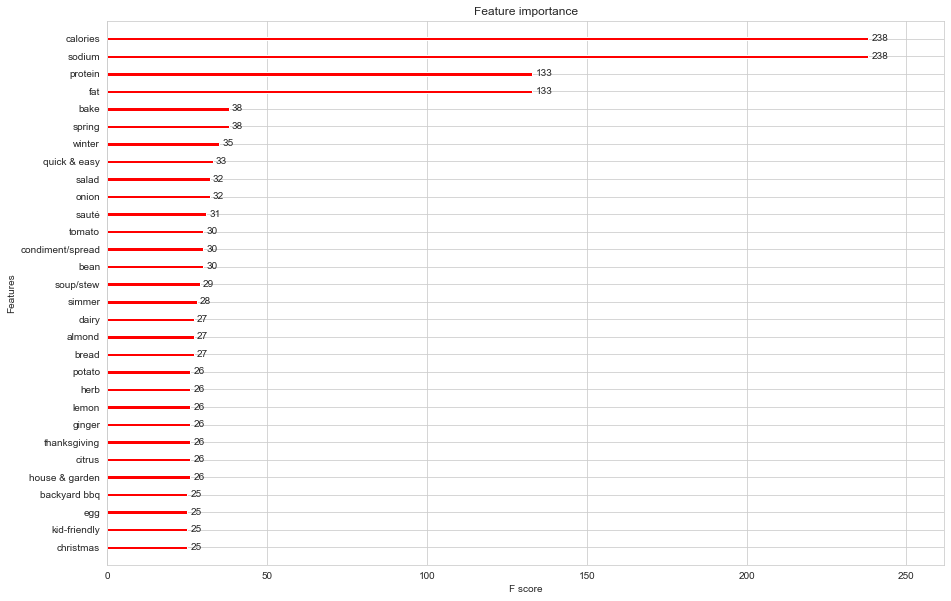

In [29]:
# Option 1: use the plot_importance function:
plt.figure(figsize=(15,10))
xgb.plot_importance(xgb_reg_best, max_num_features=30, color='red')
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

Text(0, 0.5, 'Features')

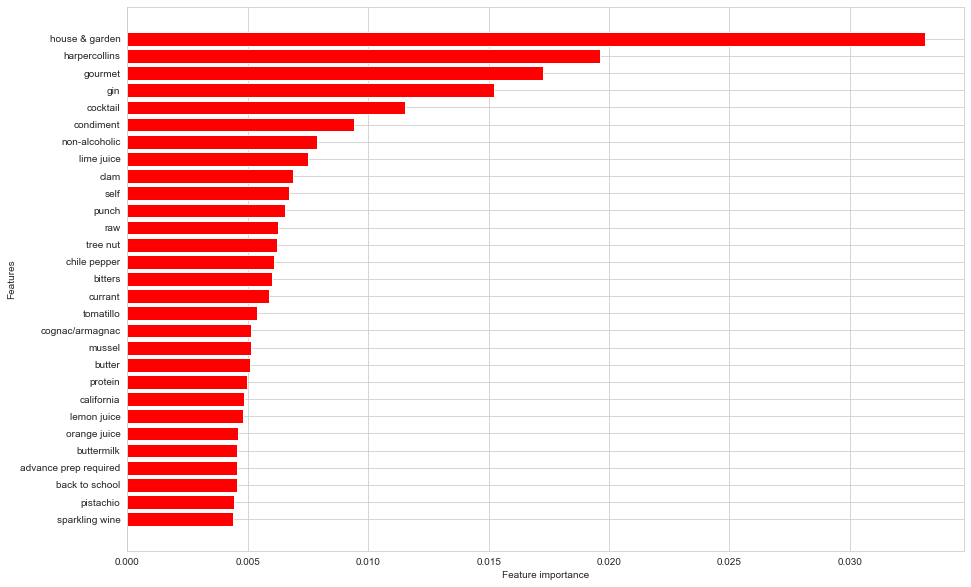

In [27]:
# Option 2: use feature_importances_ 
sorted_idx = xgb_reg_best.feature_importances_.argsort()
plt.barh(recip2.columns[2:][sorted_idx][-30:-1], xgb_reg_best.feature_importances_[sorted_idx][-30:-1],color="red")
plt.xlabel("Feature importance")
plt.ylabel("Features")

You may notice that the two methods do not return the same results. 

According to [this answer on Stackexchange](https://datascience.stackexchange.com/questions/34209/xgboost-quantifying-feature-importances):

1. `XGBRegressor.feature_importances_` returns weights that sum up to one.

2. `xgboost.plot_importance(XGBRegressor` displays the values returned by another built in importance measure, `XGBRegressor.get_booster().get_score(importance_type='weight')` which returns occurrences of the features in splits. If we divide these occurrences by their sum, we get the above described weights, with the exception that here, features with 0 importance will be excluded.

So it appears that this is also somehow related to the scale of the varibles: the nutritional variables have a higher sum, therefore despite XGBoost using them in many of the splits (see the first plot), when we divide the number of split occurrences by the variables' sum, it appears as if these features were not important. Looking at the plots, it seems that the second method (first in this list) is more similar to the plots for lasso and ridge. However, I assume that the first method captures *true* feature importance better, and that the lasso and ridge plots would look more like the first plot, had the nutritional variables been scaled. 


Lastly, let us take advantage of one more amazing feature of XGBoost: its ability to handle NaNs. Remember that in the original database we had 5000 more recipes, with NaNs instead of some nutritional information. We can simply run XGBoost on this data, without the need to do any cleaning. This dataset still has all the variables, even the tags that only occur very few times among the recipes. Let's see if this extra data causes an improvement in the root mean squared error of a test set!

In [28]:
X_2,y_2=recip.iloc[:,2::],recip.iloc[:,1]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=24)

xgb_reg_2 = xgb.XGBRegressor(objective ='reg:squarederror',
                colsample_bytree = best_hyperparams["colsample_bytree"], 
                learning_rate = 0.2,
                max_depth = int(best_hyperparams["max_depth"]), alpha = best_hyperparams["reg_alpha"],
                n_estimators = space["n_estimators"],
                min_child_weight=best_hyperparams["min_child_weight"],
                gamma=best_hyperparams["gamma"],
                subsample=best_hyperparams["subsample"])

xgb_reg_2.fit(X_train_2,y_train_2)
preds = xgb_reg_2.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE:",rmse)

RMSE: 1.1856598071603122


RMSE has increased as compared to its value on the cleaned dataset. This is no surprise, given that in this case, XGBoost had to predict a rating for recipes without nutrition information roughly 1/4-th of the time. Since, nutritional variables are among the most important, this result is still quite impressive.

## 4. Summary <a class="anchor" id="summary"></a>

We explored a high-dimensional dataset of recipes and predicted recipe ratings using lasso and ridge regressions and XGBoost. XGBoost achieved better predictive performance, but with lasso and ridge, we can better the examine the effect of each feature.

### References
* [1] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* [2] https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e
* [3] https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
* [4] https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
* [5] https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f